# Introduction

We are tasked with training a feed forward neural network using only Pandas and Numpy on the Fashion MNIST dataset. 


In [14]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Question 1

Plot one image of every class present in the MNIST dataset.

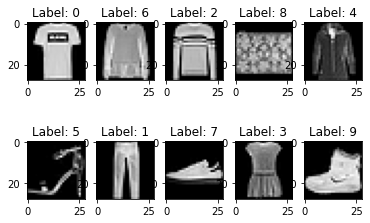

In [24]:
seen_datasets = set()
figure, axis = plt.subplots(2, 5)
for index in range(len(x_train)):
    image = x_train[index]
    label = y_train[index]
    if label not in seen_datasets:
        seen_datasets.add(label)
        axis[label%2, label%5].imshow(image, cmap='gray')
        axis[label%2, label%5].set_title(f"Label: {label}")
